A notebook for making a 100-frame movie from 3D dust for Linnea as a test

Two environment variables need to be set in bash: DROPBOX_ROOT, and FFMPEG_ROOT. The DROPBOX_ROOT folder is the path to the top level directory of the dust-holgrams folder shared by Josh. E.g. in bash,

export DROPBOX_ROOT='/Users/catherinezucker/Dropbox/dust-holograms/'

You can also set the path to the FFMPEG executable:

export FFMPEG_PATH='/usr/local/bin'

Ideally, you would set these in your bash_profile profile  (now called zprofile in the latest OS operating systems). Alternatively, if you want to set one of these variables locally in this notebook, you can use:

```
import os
os.environ['DROPBOX_ROOT'] = '/Users/catherinezucker/Dropbox/dust-holograms'
os.environ['FFMPEG_ROOT'] = '/Usr/local/bin'

```

First thing we need to do is figure out how to write some json

In [1]:
import json
import numpy as np
import os
%matplotlib inline
#%matplotlib notebook
from matplotlib import pyplot as plt
from astropy import table

Josh is having some trouble with ```.zprofile``` so:

In [2]:
if (os.environ.keys() != 'DROPBOX_HOME'):
    os.environ['DROPBOX_ROOT'] = '/Users/jegpeek/Dropbox/dust-holograms'
    os.environ['FFMPEG_ROOT'] = '/Users/jegpeek/'

Using a variable called ```run_name``` to record everything we need about the run

In [3]:
def define_paths(run_name):
    if os.path.isdir("{}/{}/".format(os.environ['DROPBOX_ROOT'],run_name)) == False:
        os.mkdir("{}/{}/".format(os.environ['DROPBOX_ROOT'],run_name))
        os.mkdir("{}/{}/frames/".format(os.environ['DROPBOX_ROOT'],run_name))

This is the camera properties, which we will fix.

In [4]:
arc = False
if arc:
    ec = "szyz"
if not arc:
    ec = "rxyz"

t = True
cprops ={
    "projection": "stereographic",
    "step_size": 1,
    "max_dist": 500.0,
    "fov": 45.0,
    "x_pix": 60,
    "y_pix": 40,
    "vmax": "auto",
    "clip_mode": "tanh",
    "fuzzy": t,
    "randomize_angles": t,
    "euler_convention": ec}

In [5]:
print(cprops)

{'projection': 'stereographic', 'step_size': 1, 'max_dist': 500.0, 'fov': 45.0, 'x_pix': 60, 'y_pix': 40, 'vmax': 'auto', 'clip_mode': 'tanh', 'fuzzy': True, 'randomize_angles': True, 'euler_convention': 'rxyz'}


_In arc mode_ Linnea asked for 100 frames orbiting around a point with equal distance. We'll assume that the middle of these 100 frames is the Sun, and we'll set some sweep out angle in the Galactic Plane.

In [6]:
nframes = 9 # 100 frames
if arc:
    angle_sweep = 45 # half of this CCW and half CW from the sun

In [7]:
def sweep(xc, yc, angle_sweep, nframes):
    R = np.sqrt(xc**2+ yc**2)
    phi =np.arctan2(yc, xc)*180/np.pi
    dangs = np.linspace(0, angle_sweep, nframes)
    xs = xc - R*np.cos((phi-angle_sweep/2+dangs)*np.pi/180)
    ys = yc - R*np.sin((phi-angle_sweep/2+dangs)*np.pi/180)
    angs = (dangs-angle_sweep/2+phi)*np.pi/180 ## wait are these in RADIANs??
    return xs, ys, angs

In [8]:
def plot_ang(x0, y0, xs, ys, run_name):
    plt.figure(figsize=[5, 5])
    plt.scatter(x0, y0)
    plt.scatter(0, 0, c='red')
    plt.plot(xs, ys)
    plt.xlim([-500, 500])
    plt.ylim([-500, 500])
    plt.title(run_name)
    plt.savefig('{}/{}/arc_{}'.format(os.environ['DROPBOX_ROOT'],run_name,run_name))

In [9]:
def plot_track(xts, yts, xc, yc, run_name):
    plt.figure(figsize=[5, 5])
    plt.scatter(xts, yts)
    plt.scatter(0, 0, c='C1')
    plt.scatter(xc, yc, c='C2')
    plt.xlim([-500, 500])
    plt.ylim([-500, 500])
    plt.title(run_name)
    plt.savefig('{}/{}/arc_{}'.format(os.environ['DROPBOX_ROOT'],run_name,run_name))

In track mode we'll move from one point to another while pointing at the cloud and keeping to top of the camera perpindicular to the plane that contains the track and cloud

Given the current position of the viewer, the unit direction toward the start of the track, and the cloud position, compute the angles of rotation

In [10]:
def determine_angles(v_pos, c_pos, t_hat):
    x_hat = np.array([1, 0, 0])
    y_hat = np.array([0, 1, 0])
    z_hat = np.array([0, 0, 1])
    # the vector to the cloud
    c_vec = c_pos-v_pos
    # the unit vector toward the cloud
    c_hat = c_vec/np.sqrt(np.sum(c_vec**2))
    
    #FIRST
    # the unit vector perp to the plane containing the track and the cloud
    n_OCT = np.cross(c_hat, t_hat) #CHECK ORDER ####FLIPPED
    n_hat_OCT = n_OCT/np.sqrt(np.sum(n_OCT**2))
    #print('n_hat_OCT', n_hat_OCT)
    #print('c_hat', c_hat)
    #print('v_pos', v_pos)
    #print('c_vec', c_vec)
    #print('c_pos', c_pos)
    # find the new orientation of the side of the camera
    v_y_prime = np.cross(n_hat_OCT, x_hat) #CHECK ORDER (correct)
    v_hat_y_prime = v_y_prime/np.sqrt(np.sum(v_y_prime**2))
    # and find the angle to rotate first
    theta = np.arccos(np.dot(v_hat_y_prime,y_hat))
    #print('theta', theta)
    #print('v_hat_y_prime',v_hat_y_prime)
    
    #SECOND
    # the unit vector perp to the plane that contains the rotation 
    #n_phi = np.cross(v_hat_y_prime, x_hat) #CHECK ORDER ###FLIPPED
    #n_hat_phi = n_phi/np.sqrt(np.sum(n_phi**2))
    # the vector being rotated to
    #v_x_prime_prime = np.cross(n_hat_OCT,n_hat_phi) #CHECK ORDER (correct)
    #### OOOPS
    v_x_prime_prime = np.cross(v_hat_y_prime, n_hat_OCT)
    v_hat_x_prime_prime = v_x_prime_prime/np.sqrt(np.sum(v_x_prime_prime**2))
    # and the angle rotated
    phi = np.arccos(np.dot(v_hat_x_prime_prime, x_hat)) ###ORIGINAL
   
    #FINALLY
    zeta = np.arccos(np.dot(v_hat_x_prime_prime, c_hat))
    print('c hat', c_hat)
    internal = np.zeros([3, 4])
    internal[:, 0]= c_hat
    internal[:, 1]=n_hat_OCT
    internal[:, 2]=v_hat_y_prime
    internal[:, 3]=v_hat_x_prime_prime
    return theta, phi, zeta, internal
    

given some inputs build a track

In [11]:
def track(xt1, yt1, zt1, xt2, yt2, zt2, nframes):
    xts = np.linspace(xt1, xt2, nframes)
    yts = np.linspace(yt1, yt2, nframes)
    zts = np.linspace(zt1, zt2, nframes)
    t_vec = np.array([xt2-xt1, yt2-yt1, zt2-zt1])
    t_hat = t_vec/np.sqrt(np.sum(t_vec**2))
    return xts, yts, zts, t_hat

In [12]:
def build_fprops(fprops, cprops, angs, xs, ys, zc):
    for i in range(nframes):
        fprops.append({
          "xyz": [xs[i], ys[i], zc],
          "angles": [angs[i], 0.0, 0.0]
        })
    allprops = {"camera_props": cprops,"frame_props":fprops }
    return allprops

In [13]:
def build_fprops_track(fprops, cprops, theatas, phis, zetas, xs, ys, zs):
    for i in range(nframes):
        fprops.append({
          "xyz": [xs[i], ys[i], zs[i]],
          "angles": [thetas[i], phis[i], zetas[i]]
        })
    allprops = {"camera_props": cprops,"frame_props":fprops }
    return allprops

Let's read in a list of molecular clouds and make movies for each one:

In [14]:
clouds = table.Table.read('{}/Holo_Cloud_Targets.csv'.format(os.environ['DROPBOX_ROOT']))
#clouds = table.Table.read('{}/Holo_TEST_Targets.csv'.format(os.environ['DROPBOX_ROOT']))

Chamaeleon
c hat [ 0.94248741 -0.26928212 -0.19800156]
[  85 -153  -50]
c hat [ 0.8900608  -0.39768674 -0.22279369]
[  85 -153  -50]
c hat [ 0.79961764 -0.54710681 -0.24755964]
[  85 -153  -50]
c hat [ 0.65834181 -0.70374469 -0.26707578]
[  85 -153  -50]
c hat [ 0.46696249 -0.84053247 -0.27468381]
[  85 -153  -50]
c hat [ 0.24971586 -0.93075911 -0.26707578]
[  85 -153  -50]
c hat [ 0.04208514 -0.96795819 -0.24755964]
[  85 -153  -50]
c hat [-0.13256225 -0.96581066 -0.22279369]
[  85 -153  -50]
c hat [-0.26928212 -0.94248741 -0.19800156]
[  85 -153  -50]
Loaded specifications for 9 images.


100% (9 of 9) |##########################| Elapsed Time: 0:00:02 ETA:  00:00:00

All workers done.
0.397824734759316
Loading map ...
Ray-casting frames ...
frame 0: vmax = 0.005758174758801033
frame 1: vmax = 0.0059493759861470605
frame 2: vmax = 0.007192619893854499
frame 3: vmax = 0.012427704554023877
frame 4: vmax = 0.02085637663317175
frame 5: vmax = 0.017477075759336002
frame 6: vmax = 0.013193035211374082
frame 7: vmax = 0.016642361310456183
frame 8: vmax = 0.013080349516065326
Worker finished.


ffmpeg version 5.0-tessus  https://evermeet.cx/ffmpeg/  Copyright (c) 2000-2022 the FFmpeg developers
  built with Apple clang version 11.0.0 (clang-1100.0.33.17)
  configuration: --cc=/usr/bin/clang --prefix=/opt/ffmpeg --extra-version=tessus --enable-avisynth --enable-fontconfig --enable-gpl --enable-libaom --enable-libass --enable-libbluray --enable-libdav1d --enable-libfreetype --enable-libgsm --enable-libmodplug --enable-libmp3lame --enable-libmysofa --enable-libopencore-amrnb --enable-libopencore-amrwb --enable-libopenh264 --enable-libopenjpeg --enable-libopus --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvmaf --enable-libvo-amrwbenc --enable-libvorbis --enable-libvpx --enable-libwebp --enable-libx264 --enable-libx265 --enable-libxavs --enable-libxvid --enable-libzimg --enable-libzmq --enable-libzvbi --enable-version3 --pkg-config-flags=--static --disable-ffplay

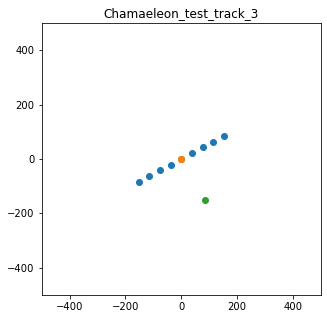

In [15]:
makeimages = True
makemovies = True
oldzeta = 0
tl=2
for c in clouds[0:1]:
    print(c['cloud'])
    run_name = c['cloud'] + '_test_track_3'
    define_paths(run_name)
    if arc:
        xs, ys, angs = sweep(c['x'], c['y'], angle_sweep, nframes)
        print(xs, ys, angs)
        plot_ang(c['x'], c['y'], xs, ys, run_name)
        # we make an empty list of frames to which we can append frames
        fprops = []
        allprops = build_fprops(fprops, cprops, angs, xs, ys, np.float(c['z']))
    if not arc:
        #hardcoding a track
        #xts, yts, zts, t_hat = track(c['xt1'], c['yt1'], c['zt1'], c['xt2'], c['yt2'], c['zt2'], nframes)
        xts, yts, zts, t_hat = track(c['y']*tl/2, c['x']*(-1)*tl/2, 0, c['y']*(-1)*tl/2, c['x']*(tl/2), 0, nframes)
        plot_track(xts, yts, c['x'], c['y'], run_name)
        fprops = []
        thetas = np.zeros(nframes)
        phis = np.zeros(nframes)
        zetas = np.zeros(nframes)
        internals = np.zeros([nframes, 3, 4])
        for j in np.arange(nframes):
            v_pos = np.array([xts[j], yts[j], zts[j]])
            c_pos = np.array([c['x'], c['y'], c['z']])
            thetas[j], phis[j], zetas[j], internals[j, :, :] = determine_angles(v_pos, c_pos, t_hat)
            print(c_pos)
            #print(thetas[j]*180/np.pi, phis[j]*180/np.pi, zetas[j]*180/np.pi,(zetas[j]-oldzeta)*180/np.pi )
            oldzeta = zetas[j]
        allprops = build_fprops_track(fprops, cprops, thetas, phis, zetas, xts, yts, zts)

    with open('{}/{}/{}.json'.format(os.environ['DROPBOX_ROOT'],run_name,run_name), 'w') as outfile:
        json.dump(allprops, outfile,indent=2)
    if makeimages:
        os.system("python3 project_frames.py {}/{}/{}.json {}/leike2020_bayestar19_splice.npy {}/{}/frames/{}_{{:05d}}.png"
          .format(os.environ['DROPBOX_ROOT'],run_name,run_name,os.environ['DROPBOX_ROOT'],os.environ['DROPBOX_ROOT'],run_name, run_name))
    if makemovies:
        os.system("{}/ffmpeg -y -r 30 -start_number 0 -i {}/{}/frames/{}_%05d.png -c:v libx264 -s 600x400 -r 30 -pix_fmt yuv420p {}/{}/{}.mp4"
          .format(os.environ['FFMPEG_ROOT'],os.environ['DROPBOX_ROOT'],run_name,run_name,os.environ['DROPBOX_ROOT'],run_name, run_name))


(-1.0, 1.0)

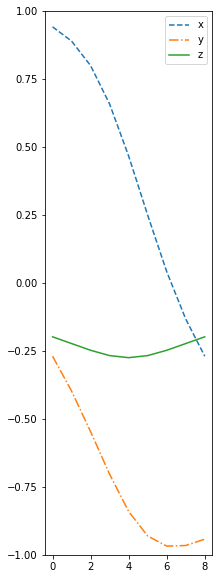

In [16]:
plt.figure(figsize=[3, 10])


plt.plot(internals[:, 0, 0], color='C0', linestyle='--')
plt.plot(internals[:, 1, 0], color='C1', linestyle='-.')
plt.plot(internals[:, 2, 0], color='C2', linestyle='-')
otherangles=False
if otherangles:
    plt.plot(internals[:, 0, 1], color='C1', linestyle='--')
    plt.plot(internals[:, 1, 1], color='C1', linestyle='-.')
    plt.plot(internals[:, 2, 1], color='C1', linestyle='-')

    plt.plot(internals[:, 0, 2], color='C2', linestyle='--')
    plt.plot(internals[:, 1, 2], color='C2', linestyle='-.')
    plt.plot(internals[:, 2, 2], color='C2', linestyle='-')

    plt.plot(internals[:, 0, 3], color='C3', linestyle='--')
    plt.plot(internals[:, 1, 3], color='C3', linestyle='-.')
    plt.plot(internals[:, 2, 3], color='C3', linestyle='-')

plt.legend(['x', 'y', 'z'])
plt.ylim([-1, 1])